#Import & Define func

In [ ]:
import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable
# import random

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Build Network

In [ ]:
activation = torch.tanh

In [ ]:
M = 20

class Net_SP(nn.Module):
    def __init__(self):
        super(Net_SP, self).__init__()
        torch.manual_seed(333) # Fix Initial_Parameter
        self.hidden_layer1 = nn.Linear(1,M)
        torch.manual_seed(333)
        self.hidden_layer2 = nn.Linear(M,M)
        torch.manual_seed(333)
        self.hidden_layer3 = nn.Linear(M,M)
        torch.manual_seed(333)
        self.hidden_layer4 = nn.Linear(M,M)
        torch.manual_seed(333)
        self.output_layer = nn.Linear(M,1)

    def forward(self, x):
        inputs = torch.cat([x],axis=1)
        layer1_out = activation(self.hidden_layer1(inputs))
        layer2_out = activation(self.hidden_layer2(layer1_out))
        layer3_out = activation(self.hidden_layer3(layer2_out))
        layer4_out = activation(self.hidden_layer4(layer3_out))
        output = self.output_layer(layer4_out)

        return output

#set PDE,residual

In [ ]:
N = 1000

In [ ]:
def f(x, net):
    u = net(x)

    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x.sum(),
                               x, create_graph=True)[0]



    pde = N*N*(0.000001)*u_xx + N*u_x + 1*torch.tensor(1, dtype=torch.float64)

    return pde


#loss,optimize

In [ ]:
import torch
import torch.nn.init as init

### (2) Model
mse_cost_function = torch.nn.MSELoss()

net_SP = Net_SP()
net_SP = net_SP.to(device)
optimizer = torch.optim.Adam(net_SP.parameters(),lr=0.0005)

#Set Observer Point

In [ ]:
x_D = np.random.uniform(low = 0 , high = 1 , size=(10000,1))

pt_x = Variable(torch.from_numpy(x_D).float(), requires_grad=False).to(device)

# Datapoint

In [ ]:
##---------------------------------Condition Domain--------------------------------##

x_0 = np.zeros((1,1))
x_N = np.ones((1,1))*N

##---------------------------------Condition Label--------------------------------##

u_x0 =  np.zeros((1,1))
u_xN =  np.zeros((1,1))

##------------------------------------Condition Domain---------------------------------------##

C_x_0 = Variable(torch.from_numpy(x_0).float(), requires_grad=True).to(device)
C_x_N = Variable(torch.from_numpy(x_N).float(), requires_grad=True).to(device)

##------------------------------------Condition Label---------------------------------------##

pt_u_x0 = Variable(torch.from_numpy(u_x0).float(), requires_grad=False).to(device)
pt_u_xN = Variable(torch.from_numpy(u_xN).float(), requires_grad=False).to(device)

##------------------------------------Set Interior Domain-----------------------------------------##

x_collocation = np.random.uniform(low=0, high=N, size=(1000,1))
all_zeros = np.zeros((1000,1))

pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True).to(device)
pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)

[0.45293346]


#Train

In [ ]:
iterations = 100000
previous_validation_loss = 99999999.0

for epoch in range(iterations):
    optimizer.zero_grad()

##-------------------------------Condition predict output------------------------------------##

    net_x0_out = net_SP(C_x_0)
    net_xN_out = net_SP(C_x_N)

# ##------------------------------------Condition Loss-----------------------------------------##
    mse_x0t = mse_cost_function(net_x0_out, pt_u_x0)
    mse_xNt = mse_cost_function(net_xN_out, pt_u_xN)

##------------------------------------Compute Loss-----------------------------------------##

    f_out = f(pt_x_collocation, net_SP)
    mse_f = mse_cost_function(f_out, pt_all_zeros)
    loss = 10*mse_f + 20*mse_x0t + 20*mse_xNt

##------------------------------------Optimize Loss-----------------------------------------##

    loss.backward()
    optimizer.step()

##----------------------------Result-----------------------------##
    if (epoch) % 50 == 1:

        pt_u3 = net_SP(N*pt_x)
        Solution = -1*torch.exp(-1000000*pt_x)-pt_x+1

        gap3 = torch.sqrt(((Solution - pt_u3)**2).mean())/torch.sqrt((Solution**2).mean())

    if (epoch) % 100 == 1:
        print("-----------------------------------------------------------------------------")
        print("Epoch:",epoch)
        print(gap3)
        print(loss)


-----------------------------------------------------------------------------
Epoch: 1
tensor(1.0673, device='cuda:0', grad_fn=<DivBackward0>)
tensor(11.3255, device='cuda:0', grad_fn=<AddBackward0>)
-----------------------------------------------------------------------------
Epoch: 101
tensor(1.0160, device='cuda:0', grad_fn=<DivBackward0>)
tensor(9.6796, device='cuda:0', grad_fn=<AddBackward0>)
-----------------------------------------------------------------------------
Epoch: 201
tensor(1.0212, device='cuda:0', grad_fn=<DivBackward0>)
tensor(9.6037, device='cuda:0', grad_fn=<AddBackward0>)
-----------------------------------------------------------------------------
Epoch: 301
tensor(1.0155, device='cuda:0', grad_fn=<DivBackward0>)
tensor(7.9055, device='cuda:0', grad_fn=<AddBackward0>)
-----------------------------------------------------------------------------
Epoch: 401
tensor(0.8772, device='cuda:0', grad_fn=<DivBackward0>)
tensor(5.1087, device='cuda:0', grad_fn=<AddBackward

KeyboardInterrupt: 

#Plotting Prediction

<ipython-input-17-79ab09395eee>:35: RuntimeWarning: overflow encountered in exp
  plt.plot(ms_x[0],1-ms_x[0]-np.exp(-1000000*ms_x[0]),'r--')


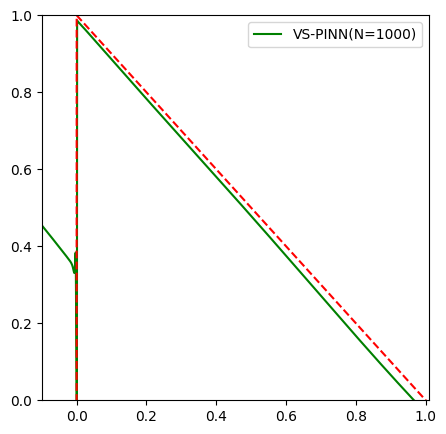

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot()

x=np.arange(-0.1,1.1,0.0001) 

ms_x = np.meshgrid(x)

x = np.ravel(ms_x).reshape(-1,1)

pt_x0 = Variable(torch.from_numpy(x).float(), requires_grad=False).to(device)

pt_u0 = net_SP(N*pt_x0)

u = pt_u0.data.cpu().numpy()

ms_u = []

for i in range(len(u)):
  ms_u.append(u[i][0])
  #print(u[i][0])

ns_u1 = []

ns_u1.append(ms_u)

surf1 = ax.plot(ms_x[0],ns_u1[0],'g')
plt.plot(ms_x[0],1-ms_x[0]-np.exp(-1000000*ms_x[0]),'r--')

plt.ylim(0,1)
plt.xlim(-0.1,1.01)
plt.show()